# 4-D phase space reconstruction
Here we test 4-d phase space reconstruction using a basic quadrupole scan and a screen. The test uses a dummy phase space distribution in the 4d transverse phase space.

### Python package imports

In [1]:
import numpy as np
import torch
import lightning as L
from gpsr.modeling import GPSR, GPSRQuadScanLattice
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator
from gpsr.datasets import QuadScanDataset, split_dataset

### Load data

Load measurment dataset and split into train and test datasets

torch.Size([20, 1]) torch.Size([20, 100, 100]) Screen(resolution=(100, 100), pixel_size=tensor([0.0010, 0.0010]), binning=1, misalignment=tensor([0., 0.]), method='kde', kde_bandwidth=tensor(0.0010), is_active=True, name='unnamed_element_0')


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


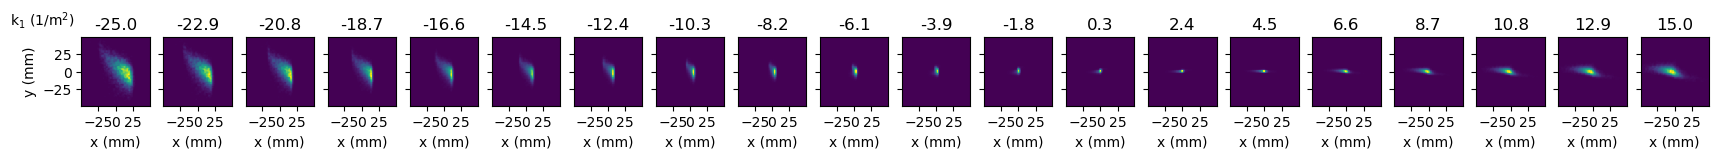

In [2]:
dset = torch.load(
    "example_data/example_datasets/reconstruction_4D.dset", weights_only=False
)
print(
    dset.parameters.shape,
    dset.observations[0].shape,
    dset.screen,
)
dset.plot_data();

In [3]:
train_k_ids = np.arange(0, len(dset.parameters), 2)
train_dset, test_dset = split_dataset(dset, train_k_ids)

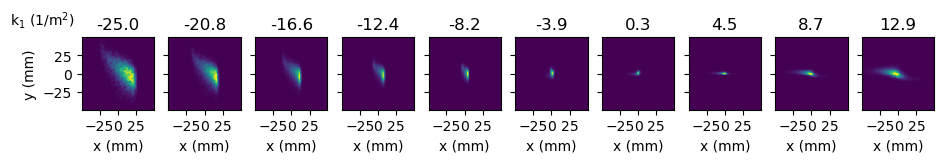

In [4]:
train_dset.plot_data();

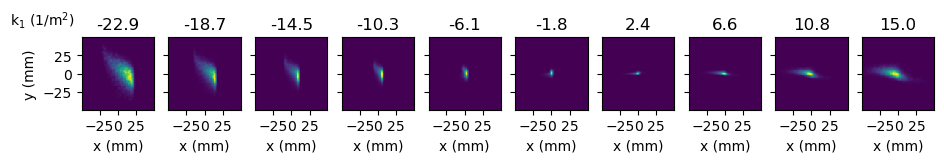

In [5]:
test_dset.plot_data();

### Create the quadrupole scan lattice
Here we use the differentiable Cheetah `Screen`. This screen uses kernel desity estimation to approximate the histogram in order to make it differentiable and vectorized.

In [6]:
# print screen information
print(train_dset.screen)
# create diagnostic lattice
p0c = 43.36e6  # reference momentum in eV/c
gpsr_lattice = GPSRQuadScanLattice(l_quad=0.1, l_drift=1.0, screen=train_dset.screen)

Screen(resolution=(100, 100), pixel_size=tensor([0.0010, 0.0010]), binning=1, misalignment=tensor([0., 0.]), method='kde', kde_bandwidth=tensor(0.0010), is_active=True, name='unnamed_element_0')


### Define the GPSR model for training
The GPSR model contains the ML-based parameterization of the initial beam distribution `NNParticleBeamGenerator` with 10k particles and the differentiable simulation of the diagnostic lattice (same one used above to generate the training data).

In [7]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c, n_dim=4), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=10)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)

### Perform the reconstruction
This cell performs the reconstruction by varying the parameters of `NNParticleBeamGenerator` to minimize the difference between predicted measurements and the training data. This step will take some time on a CPU but can be greatly accelerated (1-2 orders of magnitude) if using a GPU to do the computation. If you are limited to a CPU I would recommend reducing the number of `max_epochs` to be between 500-1000 to reduce computation time.

In [8]:
trainer = L.Trainer(limit_train_batches=100, max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.0 K  | train
--------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
c:\ProgramData\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\ProgramData\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interv

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s, v_num=50]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 28.98it/s, v_num=50]


### Get the reconstructed beam distribution

In [9]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

### Evaluate model on samples to compare predictions
Here we use the trained GPSR model to make predictions that should agree with the training data. The plot below shows the training data as the colormap and uses contour lines to show the predicted measurements at the 10th, 50th, 95th percentiles.

In [10]:
test_pred = gpsr_model(test_dset.parameters)[0].detach()
test_pred_dset = QuadScanDataset(test_dset.parameters, (test_pred,), train_dset.screen)

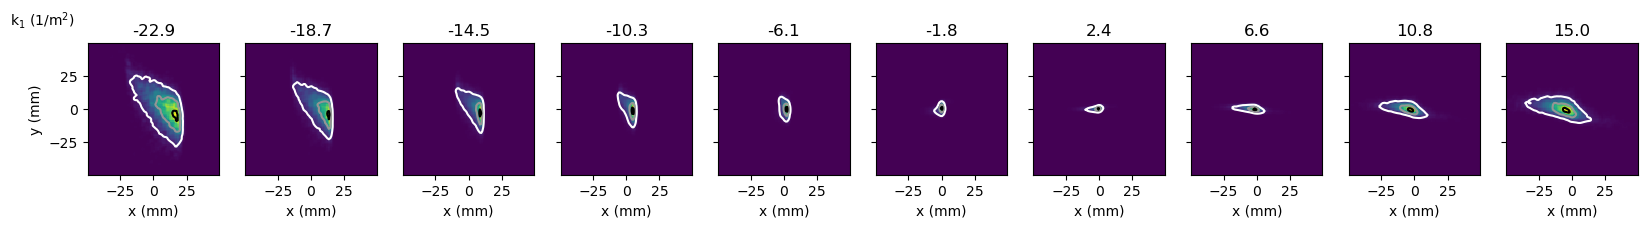

In [11]:
fig, ax = test_dset.plot_data(overlay_data=test_pred_dset)
fig.set_size_inches(20, 3)

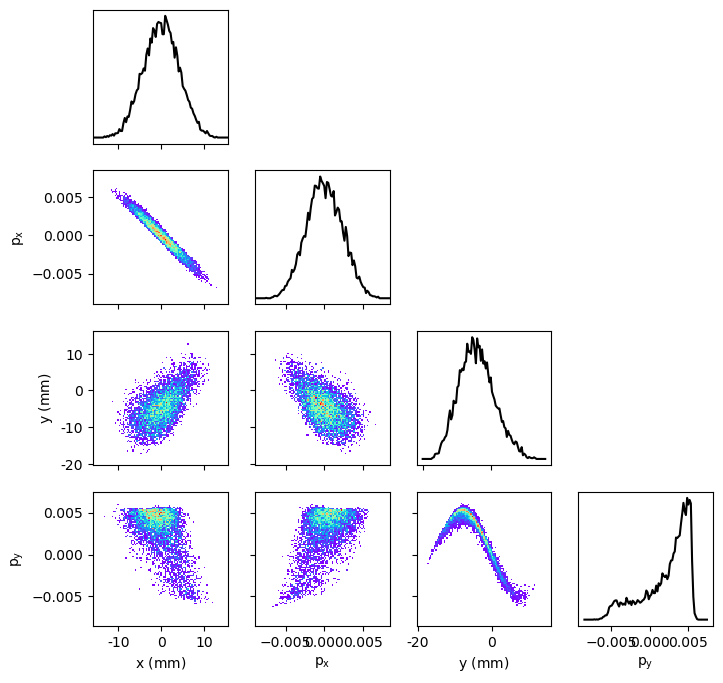

In [12]:
reconstructed_beam.plot_distribution(dimensions=("x", "px", "y", "py"));